In [101]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *
from code_generation import *
from graph_grammar import *

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
from models_and_guides import *

In [266]:
factor = nx.DiGraph()

In [267]:
nodes = [
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'KD'}),
    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('z_loc',{'type':'const', 'value':0.}),
    ('z_scale',{'type':'const', 'value':1.}),
    ('z',{'distribution':dist.Normal,'type':'latent'}),
    #('z_T',{'type':'deterministic', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('z_T',{'type':'function', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent'}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'function', 'function':torch.matmul}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent'}),
    #('diag',{'type':'deterministic', 'function':torch.diag_embed}),
    ('diag',{'type':'function', 'function':torch.diag_embed}),
]

In [268]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
    ('z','z_T',{'type':'arg'}),
    ('z_T','Wz',{'type':'arg'}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'covariance_matrix'})
]

In [269]:
plate_attr = {
    'cov_factor':{'plates':['D','K']},
    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    'z':{'plates':['N','K']},
    'z_T':{'plates':['N']}
}

In [270]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

In [271]:
nx.get_node_attributes(factor, 'plates')

{'z': ['N', 'K'],
 'z_T': ['N'],
 'cov_factor': ['D', 'K'],
 'Wz': ['N'],
 'X': ['N'],
 'cov_diag': ['D']}

/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/folzd/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


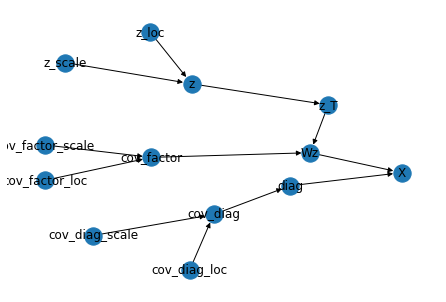

In [12]:
nx.draw(factor, with_labels=True)

In [24]:
generate_Model_class(factor)

['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['loc', 'covariance_matrix']
dict_keys(['loc', 'covariance_matrix', 'precision_matrix', 'scale_tril'])
['loc', 'covariance_matrix']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']


In [25]:
pyro.clear_param_store()

In [26]:
from model import DAGModel

In [27]:
N = 1000
D = 10
K = 4

In [28]:
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')

In [29]:
dagmodel.batch_size = N

In [30]:
tmp = dagmodel.model(torch.zeros(N,D))

In [31]:
tmp.shape

torch.Size([1000, 10])

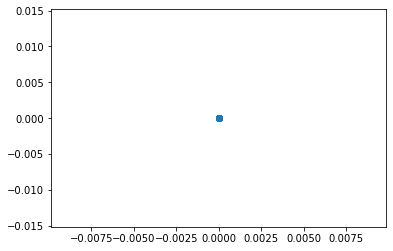

In [32]:
plt.scatter(*tmp[:,:2].detach().T)

In [33]:
foo = dagmodel.unconditioned_model(torch.zeros(N,D))

In [34]:
pyro.clear_param_store()

In [35]:
pyro.set_rng_seed(42)

zeroMeanFactor_teacher = ZeroMeanFactor(torch.empty(N,D), K, N, '0')

dgp = zeroMeanFactor_teacher.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()

data, test_data = train_test_split(X)

In [36]:
data.shape

torch.Size([900, 10])

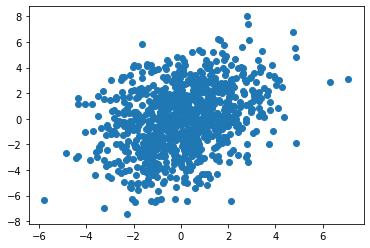

In [37]:
plt.scatter(*data[:,:2].T)

In [38]:
from inference import *

In [39]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [40]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 41.6308708190918
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................\Interrupted by user after 615 iterations.



In [41]:
dagmodel.sample_posterior_predictive(N)

In [42]:
foo = dagmodel.posterior_predictive(data)

In [43]:
foo['cov_factor_id'].shape

torch.Size([1000, 4, 10])

In [44]:
foo['cov_diag_id'].shape

torch.Size([1000, 1, 10])

In [45]:
foo['obs'].shape

torch.Size([1000, 1, 32, 10])

In [46]:
foo['z_id'].shape

torch.Size([1000, 4, 32])

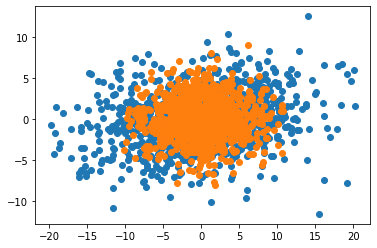

In [47]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

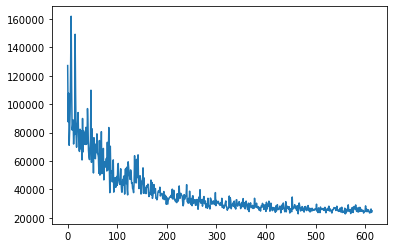

In [48]:
plt.plot(telemetry['loss'])

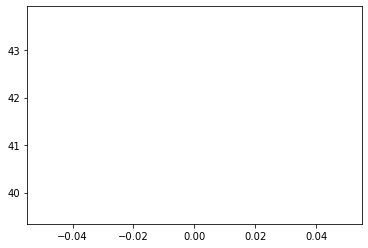

In [49]:
plt.plot(telemetry['MNLL'])

In [ ]:
marg_factor = marginalize_factor(factor)

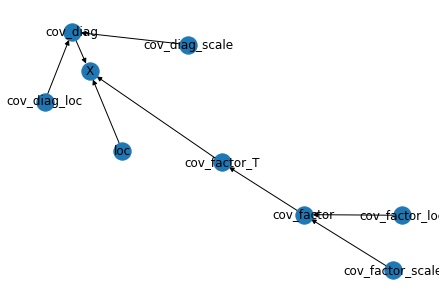

In [74]:
nx.draw(marg_factor, with_labels=True)

In [75]:
from models_and_guides import *

In [76]:
generate_Model_class(marg_factor)

['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['cov_diag', 'loc', 'cov_factor']
dict_keys(['loc', 'cov_factor', 'cov_diag'])
['loc', 'cov_factor', 'cov_diag']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']
['loc', 'scale']
dict_keys(['loc', 'scale'])
['loc', 'scale']


In [273]:
from model import DAGModel

pyro.clear_param_store()
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [277]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [278]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 35.595420837402344
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................\Interrupted by user after 452 iterations.



In [84]:
dagmodel.sample_posterior_predictive(N)

In [85]:
foo = dagmodel.posterior_predictive(data)

In [93]:
foo['obs'].shape

torch.Size([1000, 1, 32, 10])

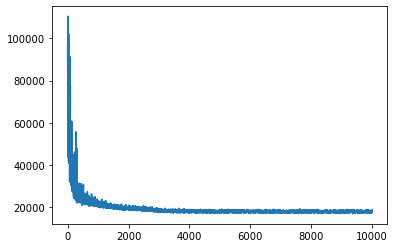

In [94]:
plt.plot(telemetry['loss'])

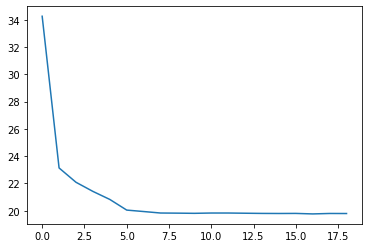

In [95]:
plt.plot(telemetry['MNLL'])

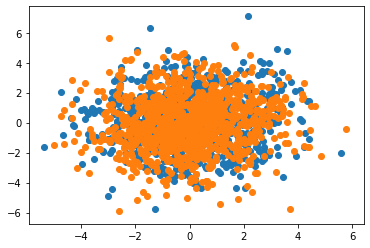

In [92]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [102]:
marg_factor

In [104]:
list(marg_factor.predecessors('X'))

['cov_factor_T', 'cov_diag', 'loc']

In [196]:
mixture = marg_factor.copy()
# From among nodes going into the observed node (e.g. mean, cov_factor, cov_diag for factor model), 
# select between one and all that won't be shared (e.g. if mean is selected, cov_factor and cov_diag will be shared)
# For now, select all

parents_of_X = list(marg_factor.predecessors('X'))
nodes_to_add_to_new_plate = nx.algorithms.ancestors(mixture, 'X')

# Put the selected nodes, and all their ancestors, onto a new plate, which is indexed
for node in nodes_to_add_to_new_plate:
    if 'plates' in mixture.nodes[node]:
        mixture.nodes[node]['plates'] = ['C'] + mixture.nodes[node]['plates']
    else:
        mixture.nodes[node]['plates'] = ['C']
# Need to generate init statements for all the params, with plate index as id
nodes = [
    # Add a dirichlet mixing proportions node, with a concentration parameter parent.
    ('mixing_proportions_concentration',{'type':'param','shape':'C','constraint':'positive'}),
    ('mixing_proportions',{'distribution':dist.Dirichlet,'type':'latent'}),
    # Add a categorical assignment node to the observation plate, child of the dirichlet node, with an infer={'enumerate': 'parallel'} attribute.
    ('assignment',{'distribution':dist.Categorical,'type':'latent','plates':['N']})
]
# Add an indexing node per parent of X
for node in parents_of_X:
    nodes.append(
        (node+'_idx', {'type':'function', 'function':torch.index_select, 'args':(Num(0),), 'plates':['N']})
    )
edges = [
    ('mixing_proportions_concentration','mixing_proportions',{'type':'param','param':'concentration'}),
    ('mixing_proportions','assignment',{'type':'param','param':'probs'}),
]
for node in parents_of_X:
    # from node to indexed node
    edges.append((node,node+'_idx',{'type':'arg'}))
    # from assignment to indexed node
    edges.append(('assignment',node+'_idx',{'type':'arg'}))
    # from indexed node to X
    edges.append((node+'_idx','X',mixture.edges[(node,'X')]))
    mixture.remove_edge(node,'X')
mixture.add_nodes_from(nodes)
mixture.add_edges_from(edges)

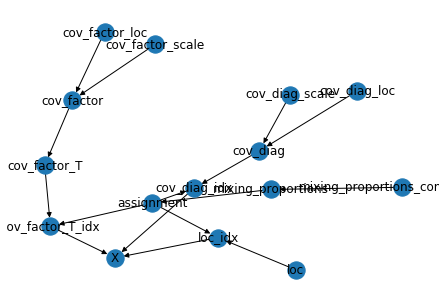

In [199]:
nx.draw(mixture, with_labels=True)

In [283]:
nx.get_node_attributes(mixture, 'plates')

{'cov_diag_loc': ['C'],
 'cov_diag_scale': ['C'],
 'cov_factor_loc': ['C'],
 'cov_factor_scale': ['C'],
 'cov_factor': ['C', 'D', 'K'],
 'X': ['N'],
 'cov_diag': ['C', 'D'],
 'loc': ['C'],
 'cov_factor_T': ['C'],
 'assignment': ['N'],
 'cov_factor_T_idx': ['N'],
 'cov_diag_idx': ['N'],
 'loc_idx': ['N']}

In [308]:
#generate_Model_class(marg_factor)
generate_Model_class(mixture)

In [314]:
from model import DAGModel

In [315]:
pyro.clear_param_store()
C = 2
dagmodel = DAGModel(torch.zeros(N,D),K,C,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

ValueError: Shape mismatch inside plate('CDK_id') at site cov_factor_id dim -3, 4 vs 2

In [316]:
%debug

> /home/folzd/anaconda3/lib/python3.7/site-packages/pyro/poutine/broadcast_messenger.py(59)_pyro_sample()
     57                 if target_batch_shape[f.dim] is not None and target_batch_shape[f.dim] != f.size:
     58                     raise ValueError("Shape mismatch inside plate('{}') at site {} dim {}, {} vs {}".format(
---> 59                         f.name, msg['name'], f.dim, f.size, target_batch_shape[f.dim]))
     60                 target_batch_shape[f.dim] = f.size
     61             # Starting from the right, if expected size is None at an index,

ipdb> u
> /home/folzd/anaconda3/lib/python3.7/contextlib.py(74)inner()
     72         def inner(*args, **kwds):
     73             with self._recreate_cm():
---> 74                 return func(*args, **kwds)
     75         return inner
     76 

ipdb> u
> /home/folzd/anaconda3/lib/python3.7/site-packages/pyro/poutine/plate_messenger.py(15)_process_message()
     13     def _process_message(self, msg):
     14         super(